## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
  #  print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional 
layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Dropout(p=0.25),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.25),
            nn.Linear(100,10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
       BatchNorm1d-4                  [-1, 200]             400
           Dropout-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
              ReLU-7                  [-1, 100]               0
       BatchNorm1d-8                  [-1, 100]             200
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 178,710
Trainable params: 178,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.68
Estimated T

Your experiments come here:

In [ ]:
import torch.nn.functional as F

model = TinyNeuralNetwork().to(device)
opt =  torch.optim.Adam(model.parameters(),lr=0.001)
loss_func = nn.CrossEntropyLoss()
history=[]
# Your experiments, training and validation loops here
            

In [ ]:
def train_model (model, train_loder, test_loader, loss_fn, opt, n_epochs: int):
  train_loss = []
  test_loss = []
  test_accuracy = []


  for epoch in range(n_epochs):
    ep_train_loss = []
    ep_test_loss = []
    ep_test_accuracy  = []
    model.train(True)
    for X_batch, y_batch in train_loader:
      opt.zero_grad()

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      predictions = model(X_batch)
      loss = loss_fn(predictions, y_batch)

      loss.backward()
      opt.step()
      ep_train_loss.append(loss.item())


    model.train(False)
    with torch.no_grad():
      for X_batch, y_batch in test_loader:
         X_batch = X_batch.to(device)
         y_batch = y_batch.to(device)
         predictions = model(X_batch)
         loss = loss_fn(predictions, y_batch)

         ep_test_loss.append(loss.item())
         y_pred=predictions.max(1)[1].data
         ep_test_accuracy.append(np.mean ((y_batch.cpu() == y_pred.cpu()).numpy()))

    print(f"Epoch {epoch+1}  of {n_epochs}")

    train_loss.append(np.mean(ep_train_loss))
    test_loss.append(np.mean(ep_test_loss))
    test_accuracy.append(np.mean(ep_test_accuracy))

    print (f"training loss = {train_loss[-1]:.6f}")
    print (f"test loss = {test_loss[-1]:.6f}")
    print (f"test acc= {test_accuracy[-1]:.3f}")

  return train_loss, test_loss, test_accuracy

In [ ]:
n_epochs = 70

train_loss, test_loss, test_accuracy  = train_model(model, train_loader, test_loader, loss_func, opt,n_epochs)

Epoch 1  of 70
training loss = 0.522171
test loss = 0.422190
test acc= 0.847
Epoch 2  of 70
training loss = 0.421358
test loss = 0.433804
test acc= 0.848
Epoch 3  of 70
training loss = 0.395275
test loss = 0.393634
test acc= 0.858
Epoch 4  of 70
training loss = 0.378299
test loss = 0.365187
test acc= 0.867
Epoch 5  of 70
training loss = 0.358260
test loss = 0.357341
test acc= 0.875
Epoch 6  of 70
training loss = 0.349799
test loss = 0.354333
test acc= 0.870
Epoch 7  of 70
training loss = 0.344473
test loss = 0.338978
test acc= 0.878
Epoch 8  of 70
training loss = 0.333215
test loss = 0.349901
test acc= 0.877
Epoch 9  of 70
training loss = 0.333483
test loss = 0.355677
test acc= 0.876
Epoch 10  of 70
training loss = 0.328464
test loss = 0.341878
test acc= 0.879
Epoch 11  of 70
training loss = 0.324245
test loss = 0.327998
test acc= 0.882
Epoch 12  of 70
training loss = 0.313840
test loss = 0.325635
test acc= 0.883
Epoch 13  of 70
training loss = 0.309381
test loss = 0.338952
test acc= 0

In [ ]:
def plot_train_process(train_loss, test_loss, test_accuracy):
  fig, axes = plt.subplots(1, 2 ,figsize=(15,5))

  axes[0].set_title("Loss")
  axes[0].plot(train_loss, label='train')
  axes[0].plot(test_loss, label='test')
  axes[0].legend()

  axes[1].set_title("Acc")
  axes[1].plot(test_accuracy)

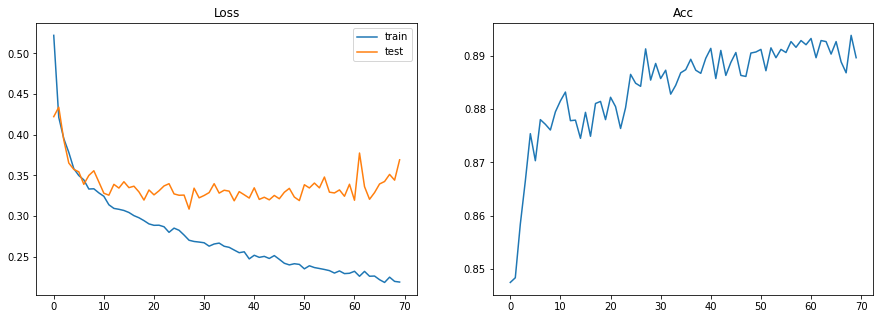

In [ ]:
plot_train_process(train_loss, test_loss, test_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100,10)  

        )
        
    def forward(self, inp):       
        out = self.model(inp)

        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
       BatchNorm1d-4                  [-1, 200]             400
            Linear-5                  [-1, 100]          20,100
              ReLU-6                  [-1, 100]               0
       BatchNorm1d-7                  [-1, 100]             200
            Linear-8                   [-1, 10]           1,010
Total params: 178,710
Trainable params: 178,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated Total Size (MB): 0.70
----------------------------------------------------------------


In [ ]:
model1 = OverfittingNeuralNetwork().to(device)
opt1 =  torch.optim.Adam(model1.parameters(),lr=0.001)
loss_func1 = nn.CrossEntropyLoss()


In [ ]:
n_epochs = 50
train_loss1, test_loss1, test_accuracy1  = train_model(model1, train_loader, test_loader, loss_func1, opt1,n_epochs)

Epoch 1  of 50
training loss = 0.459615
test loss = 0.427899
test acc= 0.844
Epoch 2  of 50
training loss = 0.356162
test loss = 0.393886
test acc= 0.857
Epoch 3  of 50
training loss = 0.323673
test loss = 0.363021
test acc= 0.867
Epoch 4  of 50
training loss = 0.299727
test loss = 0.368278
test acc= 0.868
Epoch 5  of 50
training loss = 0.284738
test loss = 0.343543
test acc= 0.875
Epoch 6  of 50
training loss = 0.273968
test loss = 0.356662
test acc= 0.871
Epoch 7  of 50
training loss = 0.258420
test loss = 0.336102
test acc= 0.878
Epoch 8  of 50
training loss = 0.250862
test loss = 0.387057
test acc= 0.862
Epoch 9  of 50
training loss = 0.243678
test loss = 0.343645
test acc= 0.877
Epoch 10  of 50
training loss = 0.235318
test loss = 0.340210
test acc= 0.879
Epoch 11  of 50
training loss = 0.226725
test loss = 0.352197
test acc= 0.878
Epoch 12  of 50
training loss = 0.220788
test loss = 0.356688
test acc= 0.880
Epoch 13  of 50
training loss = 0.209593
test loss = 0.341067
test acc= 0

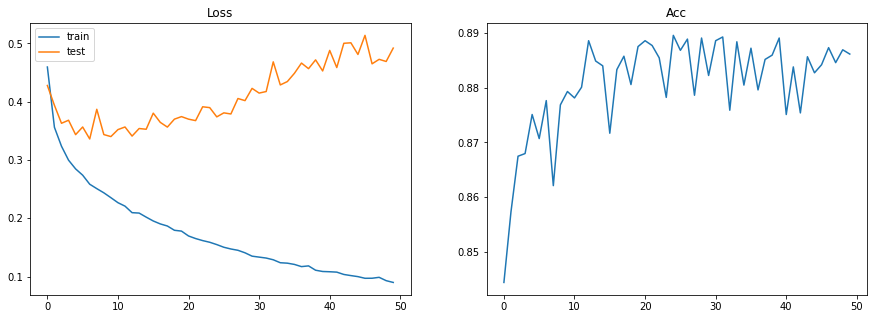

In [ ]:
plot_train_process(train_loss1, test_loss1, test_accuracy1)

Тадаааа


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), nn.Flatten(), 
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Dropout(p=0.6),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.6),
            nn.Linear(100,10)  
            
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Flatten-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
       BatchNorm1d-5                  [-1, 200]             400
           Dropout-6                  [-1, 200]               0
            Linear-7                  [-1, 100]          20,100
              ReLU-8                  [-1, 100]               0
       BatchNorm1d-9                  [-1, 100]             200
          Dropout-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
Total params: 178,710
Trainable params: 178,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
model2 = FixedNeuralNetwork().to(device)
opt2 =  torch.optim.Adam(model2.parameters(),lr=0.001)
loss_func2 = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 50
train_loss2, test_loss2, test_accuracy2  = train_model(model2, train_loader, test_loader, loss_func2, opt2,n_epochs)

Epoch 1  of 50
training loss = 0.712822
test loss = 0.478135
test acc= 0.820
Epoch 2  of 50
training loss = 0.545617
test loss = 0.431024
test acc= 0.842
Epoch 3  of 50
training loss = 0.516746
test loss = 0.413743
test acc= 0.847
Epoch 4  of 50
training loss = 0.493364
test loss = 0.437128
test acc= 0.838
Epoch 5  of 50
training loss = 0.483768
test loss = 0.401579
test acc= 0.854
Epoch 6  of 50
training loss = 0.473334
test loss = 0.397924
test acc= 0.854
Epoch 7  of 50
training loss = 0.469125
test loss = 0.395748
test acc= 0.856
Epoch 8  of 50
training loss = 0.464014
test loss = 0.391790
test acc= 0.856
Epoch 9  of 50
training loss = 0.458875
test loss = 0.389152
test acc= 0.858
Epoch 10  of 50
training loss = 0.450075
test loss = 0.392530
test acc= 0.857
Epoch 11  of 50
training loss = 0.442828
test loss = 0.383125
test acc= 0.863
Epoch 12  of 50
training loss = 0.443095
test loss = 0.384651
test acc= 0.861
Epoch 13  of 50
training loss = 0.439193
test loss = 0.377418
test acc= 0

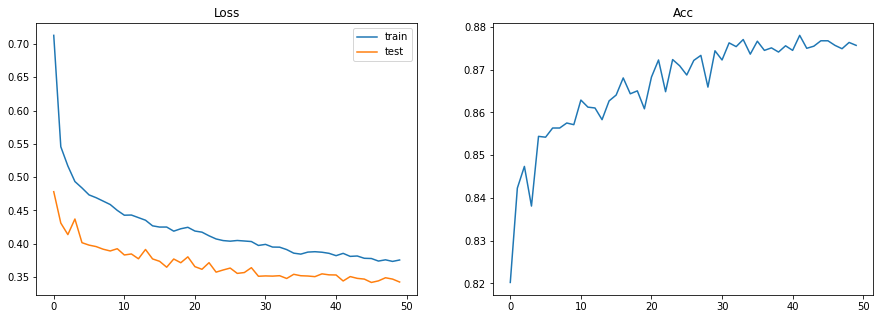

In [ ]:
plot_train_process(train_loss2, test_loss2, test_accuracy2)

### Conclusions:
_Write down small report with your conclusions and your ideas._

По итогу, 1я nn дает уверенную точность, для нее оставила "небольшое" переобучение, для сравнения со 2й и 3й(хоть подразумевалась независимость). Ее легко поправить, увеличив p например до 0.5 в слоях dropout. Плюс используется большее число эпох
во 2й сильное переобучение, не смотря на слои batchnorm, оно убирется добавлением слоем dropout с достаточно высоким p=0.6(3я nn)